# ReadMe
This file is intended to streamline the process of analyzing the data resulting from running the experiments in "falsifier.py" and "mult_obj_falsifier.py"

Note: Chatgpt was used for generating and optimally defining most of the graphing functions provided in this notebook

# Imports

In [7]:
import pandas as pd
import os
from pathlib import Path
import re
import numpy as np
import matplotlib.pyplot as plt
import math
from natsort import os_sorted
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans,AffinityPropagation
from sklearn.metrics import silhouette_samples, silhouette_score
import seaborn as sns
import matplotlib.cm as cm


# File Paths

In [23]:
per_ce_param_path = "../outputs/persistent_ce/persistent_attack_ce_ce.csv"
per_ce_dir_path = "../outputs/persistent_ce"

int_ce_param_path = "../outputs/intermittent_ce/intermittent_attack_ce_ce.csv"
int_ce_dir_path = "../outputs/intermittent_ce"

int_mab_param_path = "../outputs/intermittent_mab/intermittent_attack_mab_mab.csv"
int_mab_dir_path = "../outputs/intermittent_mab"

per_mab_param_path = "../outputs/persistent_mab/persistent_attack_mab_mab.csv"
per_mab_dir_path = "../outputs/persistent_mab"

int_mult_prio_param_path = "../outputs/intermittent_mab_w_priority_1/intermittent_attack_mab_mab.csv"
int_mult_prio_dir_path = "../outputs/intermittent_mab_w_priority_1"

per_mult_prio_param_path = "../outputs/persistent_mab_w_priority_1/persistent_attack_mab_mab.csv"
per_mult_prio_dir_path = "../outputs/persistent_mab_w_priority_1"

int_mult_equal_param_path = "../outputs/intermittent_mab_w_priority_equal/intermittent_attack_mab_mab.csv"
int_mult_equal_dir_path = "../outputs/intermittent_mab_w_priority_equal"

per_mult_equal_dir_path = "../outputs/persistent_mab_w_priority_equal"
per_mult_equal_param_path = "../outputs/persistent_mab_w_priority_equal/persistent_attack_mab_mab.csv"

int_paths = [[int_ce_dir_path,int_ce_param_path, False,"Intermittent: Cross-Entropy"],[int_mab_dir_path,int_mab_param_path,  False,
            "Intermittent: Single obj MAB"],[int_mult_equal_dir_path,int_mult_equal_param_path,True, "Intermittent: Multi obj Equal MAB"],[int_mult_prio_dir_path,int_mult_prio_param_path,True,"Intermittent: Multi Obj Priority MAB"]]

per_paths = [[per_ce_dir_path,per_ce_param_path, False,"Persistent: Cross-Entropy"],[per_mab_dir_path,per_mab_param_path, False,
            "Persistent: Single obj MAB"],[per_mult_equal_dir_path,per_mult_equal_param_path,True, "Persistent: Multi obj Equal MAB"],[per_mult_prio_dir_path,per_mult_prio_param_path,True,"Persistent: Multi Obj Priority MAB"]]


# Classify File Instances

In [9]:
def generate_velocity_csv(folder): #TODO - Either fix verifia for multi-obj or modify for that case
    """
        Builds csv containing velocity data for each simulation using the
        corresponding order of the params file returned by verifAI
    """

    ce_reg = r'.*\d_cex.*'
    nc_reg = r'.*no_cex.*'
    att_reg = r".*attacker_crash.*"


    non_ce_reg = [nc_reg,att_reg]
    

    start = os.getcwd()
    v1,v2,v3,v4 = [],[],[],[]

    files = os_sorted(os.listdir(folder))

    os.chdir(folder)
    ce_count = 0
    for file in files: #match counter-examples first
        found = re.match(ce_reg,  file)
        if found:
            file_data = pd.read_csv(file)
            v1.append(np.array(file_data["v1"]))
            v2.append(np.array(file_data["v2"]))
            v3.append(np.array(file_data["v3"]))
            v4.append(np.array(file_data["v4"]))
            ce_count+= 1

    
    for file in files: #match non counter examples second
        for reg in non_ce_reg:
            found = re.match(reg, file)
            if found:
                file_data = pd.read_csv(file)
                v1.append(np.array(file_data["v1"]))
                v2.append(np.array(file_data["v2"]))
                v3.append(np.array(file_data["v3"]))
                v4.append(np.array(file_data["v4"]))
                break

    os.chdir(start)

    return [v1,v2,v3,v4], ce_count


In [10]:

def read_folder(folder,sampler_file, attack_type,mult_obj=False,gen_graph=False):    
    """
    Data prepocessing: returns dataframe with test case specific features
    """
    velocity_data,ce_count = generate_velocity_csv(folder)


    simulation_params_df = pd.read_csv(sampler_file)

    if attack_type == "int":
        return(preprocess_intermittent(simulation_params_df,velocity_data,gen_graph,mult_obj)),ce_count
    if attack_type == "per":
        return(preprocess_persistent(simulation_params_df,velocity_data,gen_graph,mult_obj)),ce_count
    else:
        print("Error classifying attack type")


def preprocess_intermittent(sampler_data,velocities_df,gen_graph,mult_obj):
    """
    Isolates relative columns and generates some new features for analysis

    Side Effect: Generates velocity graphs over time with attack indicators
    """
    intermittent_cols = ["Unnamed: 0","point.params.random_thr_br1","point.params.random_thr_br2","point.params.inter_vehicle_distance", "point.params.random_t1", "point.params.random_t2","point.params.random_t3","point.params.random_t4","rho",]

    if not mult_obj:

        sampler_data =sampler_data[intermittent_cols]
        col_names = {
            "Unnamed: 0" : "idx",
            "point.params.random_thr_br1": "random_thr_br1",
            "point.params.random_thr_br2" : "random_thr_br2",
            "point.params.random_t1" : "random_t1",
            "point.params.random_t2" : "random_t2",
            "point.params.random_t3" : "random_t3",
            "point.params.random_t4" : "random_t4",
            "point.params.inter_vehicle_distance" : "inter_vehicle_distance",
            "rho" : "rho"
        }
    else:  
        intermittent_cols += ["rho_0", "rho_1"]
        sampler_data =sampler_data[intermittent_cols]
        col_names = {
            "Unnamed: 0" : "idx",
            "point.params.random_thr_br1": "random_thr_br1",
            "point.params.random_thr_br2" : "random_thr_br2",
            "point.params.random_t1" : "random_t1",
            "point.params.random_t2" : "random_t2",
            "point.params.random_t3" : "random_t3",
            "point.params.random_t4" : "random_t4",
            "point.params.inter_vehicle_distance" : "inter_vehicle_distance",
            "rho" : "rho2",
            "rho_0": "rho1",
            "rho_1": "rho3"
        }
    sampler_data = sampler_data.copy()
    sampler_data.rename(columns=col_names, inplace=True)
    output = get_attack_spacing_intermittent(sampler_data)
    output = velocity_at_attack_intermittent(sampler_data,velocities_df,gen_graph)
    

    return output

def preprocess_persistent(sampler_data,velocities_df,gen_graph,mult_obj):
    """
    Isolate relative columns and generates new featurs

    Side Effects: Generates velocity graphs over time with attack indicators
    """
    persistent_cols = [ "Unnamed: 0","point.params.amplitude_acc", "point.params.attack_time", "point.params.frequency", "point.params.inter_vehicle_distance", "rho"]
    if not mult_obj:
        sampler_data = sampler_data[persistent_cols]
        col_names = {
        "Unnamed: 0" : "idx",
        "point.params.amplitude_acc": "amplitude_acc",
        "point.params.attack_time" : "attack_time",
        "point.params.frequency" : "frequency",
        "point.params.inter_vehicle_distance" : "inter_vehicle_distance",
        "rho" : "rho"
    }
    else:
        persistent_cols += ["rho_0", "rho_1"]
        sampler_data =sampler_data[persistent_cols]
        col_names = {
            "Unnamed: 0" : "idx",
            "point.params.amplitude_acc": "amplitude_acc",
            "point.params.attack_time" : "attack_time",
            "point.params.frequency" : "frequency",
            "point.params.inter_vehicle_distance" : "inter_vehicle_distance",
            "rho" : "rho2",
            "rho_0": "rho1",
            "rho_1": "rho3"
        }

    sampler_data = sampler_data.copy()
    sampler_data.rename(columns=col_names, inplace=True)
    output = velocity_at_attack_persistent(velocities_df,sampler_data,gen_graph)
    return output




# Helper Functions

In [11]:
def get_attack_spacing_intermittent(intermittent_df): # Calculate distance between each attack and add to Dataframe
    attack_spacing = []
    """
        Calcluates spacing between attacks and appends to given dataframe
    
    """

    for simulation_instance in range(len(intermittent_df)):
        diff_1 = intermittent_df["random_t2"][simulation_instance] - intermittent_df["random_t1"][simulation_instance] # t2 > t1
        diff_2 = intermittent_df["random_t3"][simulation_instance] - intermittent_df["random_t2"][simulation_instance]
        diff_3 = intermittent_df["random_t4"][simulation_instance] - intermittent_df["random_t3"][simulation_instance]

        sim_gaps = np.array([diff_1,diff_2,diff_3])
        attack_spacing.append(sim_gaps)

    attack_spacing = np.array(attack_spacing)
    col_names = ["t1_t2", "t2_t3", "t3_t4"]
    time_df = pd.DataFrame(attack_spacing, columns=col_names)

    return(pd.concat([intermittent_df, time_df],axis=1))


def velocity_at_attack_intermittent(intermittent_df,velocities_df,gen_graph): # Collect the attackers speed at each attack and append to Dataframe
    """
    Calculates velocity at attack times and appends to dataframe
    """
    times = intermittent_df[["random_t1", "random_t2", "random_t3","random_t4"]]

    attk_vel = []
    for sim in range(len(times)):
        sim_vel = []
        sim_length = len(velocities_df[0][sim])
        for col in times.columns:
            idx = math.ceil(times[col][sim]) * 10
            if idx < sim_length:
                sim_vel.append(velocities_df[0][sim][idx])
            else:
                sim_vel.append(0)
        attk_vel.append(sim_vel)
        
    col_names = ["t1_velocity", "t2_velocity", "t3_velocity", "t4_velocity"]
    attk_vel = np.array(attk_vel)
    final_df = pd.DataFrame(attk_vel, columns=col_names)

    if gen_graph:
        generate_intermittent_attack_graphs(velocities_df,times,intermittent_df)

    return get_attack_spacing_intermittent((pd.concat([intermittent_df,final_df],axis=1)))


def velocity_at_attack_persistent(velocities_df, persistent_df, display):
    """
    Calcluates velocity at attack time (initial), and average velocity for the remainder of the attack
    """
    attack_times= persistent_df["attack_time"]


    velocity_at_attack = []  # construct custom features
    avg_speed_after_attck = []

    for sim_instance in range(len(attack_times)):
        attack_time = math.ceil(attack_times[sim_instance] * 10) # account for timestep length
        velocity_at_attack.append(velocities_df[0][sim_instance][attack_time]) # velocity at attack time
        avg_speed_after_attck.append(np.average(velocities_df[0][sim_instance][attack_time:])) # collect that average speed after attack has occured

    velocity_at_attack = np.array(velocity_at_attack)
    avg_speed_after_attck = np.array(avg_speed_after_attck)
    col_names = [["pre_attack_velocity"],["attack_velocity_average"]]
    temp_df = pd.DataFrame(velocity_at_attack, columns=col_names[0])
    temp_df2 = pd.DataFrame(avg_speed_after_attck,columns=col_names[1]) 

    if display:
        generate_persistent_attack_graphs(velocities_df, persistent_df["frequency"],persistent_df["amplitude_acc"],persistent_df["attack_time"])
        


    return(pd.concat([persistent_df,temp_df,temp_df2],axis=1))                                    


In [12]:
def distinguish_events(features_df, counter_ex_totals): # Todo improve or build upon to gather attacker_crash instanaces
    ce_df = features_df[:counter_ex_totals]
    non_ce_df = features_df[counter_ex_totals:]

    labels = np.concatenate((np.full(counter_ex_totals,1), np.full(len(features_df)- counter_ex_totals,0)))

    return ce_df, non_ce_df, labels

# Visualization Tools

In [13]:
def generate_persistent_attack_graphs(sim_velocities,att_freq,att_amplitude,times): # okay we gonna have to fix this up later
    """
    Graph Velocity over time w/ displayed amplitude and frequency   

    """
    for i in range(0,3):
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Two side-by-side plots

        x = range(len(sim_velocities[0][i]))

        # First subplot - Attacker vs Follower 1
        axes[0].plot(x, sim_velocities[0][i], label="Attacker")
        axes[0].plot(x, sim_velocities[1][i], linestyle="--", color="purple", label="Follower 1")

        axes[0].set_title(f"Velocity Over Time\nAttack Freq: {int(att_freq[i])}, Amp: {att_amplitude[i]:.2g}")
        axes[0].set_xlabel(f"Timesteps (.1 secs)")
        axes[0].set_ylabel("Velocity (m/s)")
        axes[0].legend()

        attack_time = math.ceil(times[i] * 10)
        axes[0].axvline(x=attack_time, color='red', alpha=0.7, label="Attack Time")

        # Second subplot - Followers 1, 2, and 3
        x_followers = range(len(sim_velocities[1][i]))
        axes[1].plot(x_followers, sim_velocities[1][i], linestyle="--", color="green", label="Follower 1")
        axes[1].plot(x_followers, sim_velocities[2][i], linestyle="--", color="blue", label="Follower 2")
        axes[1].plot(x_followers, sim_velocities[3][i], linestyle="--", color="purple", label="Follower 3")

        axes[1].set_title(f"Follower Velocities Over Time")
        axes[1].set_xlabel("Timesteps (.1 secs)")
        axes[1].set_ylabel("Velocity (m/s)")
        axes[1].legend()

        axes[1].axvline(x=attack_time, color='red', alpha=0.7, label="Attack Time")

        plt.tight_layout()  # Adjust layout for better spacing

        #plt.savefig(f"Velocity_persistent_Attack_Freq_{int(att_freq[i])}_amp_{att_amplitude[i]:.2g}_{i}_ce.jpg")
        plt.show()

def generate_intermittent_attack_graphs(velocities_list,times,intermittent_df):
    """
    Graph velocity over time w/ attack markers displaying attack start"
    
    """

    for i in range(0,3):
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Create a figure with 2 subplots side by side

        # First subplot - Attacker velocity
        x = range(len(velocities_list[0][i]))
        axes[0].plot(x, velocities_list[0][i], label="Attacker")
        axes[0].plot(x, velocities_list[1][i], linestyle="--", color="purple", label="Follower 1")

        axes[0].set_title("Attacker Velocity (m/s) with attack markers")
        axes[0].set_xlabel("Timesteps (.1 secs)")
        axes[0].set_ylabel("Velocity (m/s)")
      
        first = True
        for j in times.columns:
            attack_time = math.ceil(times[j][i] * 10)
            label = "Attack" if first else "_nolegend_"
            axes[0].axvline(x=attack_time, color='red', alpha=0.7, label=label )
            first = False


        axes[0].legend()

        # Second subplot - Followers velocity
        x = range(len(velocities_list[2][i]))
        axes[1].plot(x, velocities_list[1][i], linestyle="--", alpha=.7,  color="green", label="Follower 1")
        axes[1].plot(x, velocities_list[2][i], linestyle="--", alpha=.7, color="blue", label="Follower 2")
        axes[1].plot(x, velocities_list[3][i], linestyle="--", alpha=.7, color="purple", label="Follower 3")

        axes[1].set_title("Followers Velocity (m/s) over time with attack markers")
        axes[1].set_xlabel("Timesteps (.1 secs)")
        axes[1].set_ylabel("Velocity (m/s)")

        first = True
        for j in times.columns:
            attack_time = math.ceil(times[j][i] * 10)
            label = "Attack" if first else "_nolegend_"
            axes[1].axvline(x=attack_time, color='red', alpha=0.7, label=label )
            first = False

        axes[1].legend()

        # Determine shared limits for x-axis and y-axis
        x_min = 0
        x_max = max(len(velocities_list[0][i]), len(velocities_list[2][i]))

        y_min = min(
            min(velocities_list[0][i]), min(velocities_list[1][i]),
            min(velocities_list[2][i]), min(velocities_list[3][i])
        )
        y_max = max(
            max(velocities_list[0][i]), max(velocities_list[1][i]),
            max(velocities_list[2][i]), max(velocities_list[3][i])
        )

        # Apply limits to both subplots
        axes[0].set_xlim(x_min, x_max)
        axes[1].set_xlim(x_min, x_max)
        axes[0].set_ylim(y_min, y_max)
        axes[1].set_ylim(y_min, y_max)


       # plt.savefig(f"intermittent_velocity_{i}_ce.jpg")
        plt.tight_layout()  # Adjust layout to fit both plots properly
        plt.show()


# Cofactor Analysis

Looking at the correlation between the different parameters and robustness is ambiguous when considering all examples with the single objective sampling. However, we can gaurentee that for counterexamples the robustness value attributed to the sampled scenario actually corresponds to the adversarys performance or attack success so this can provide some information

In [34]:
def cofactor_preprocess(dir_path,file_path,type,mult):
    data, count = read_folder(dir_path,file_path,type,mult_obj=mult)

    if type == "int":
        data = data.drop(columns=["random_t2", "random_t3","random_t4"])
    data = data.drop(columns=["idx"])
    cols = data.columns
    ce_data, non_ce_data,_ = distinguish_events(data,count) #  isolate counter examples
    
    ce_data = StandardScaler().fit_transform(ce_data)
    non_ce_data = StandardScaler().fit_transform(non_ce_data)

    return (ce_data,non_ce_data,cols,data)

def cofactor_analysis(ce, non_ce,cols, title):
    feature_names = cols 
    X_ce = np.array(ce)
    X_non_ce = np.array(non_ce)
    
    X_ce_scaled = StandardScaler().fit_transform(X_ce)
    X_non_ce_scaled = StandardScaler().fit_transform(X_non_ce)
    
    corr_matrix_ce = np.corrcoef(X_ce_scaled.T)
    corr_matrix_non_ce = np.corrcoef(X_non_ce_scaled.T)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
    
    im1 = ax1.imshow(corr_matrix_ce, cmap="RdBu_r", vmin=-1, vmax=1)
    ax1.set_xticks(range(len(feature_names)))
    ax1.set_xticklabels(feature_names)
    ax1.set_yticks(range(len(feature_names)))
    ax1.set_yticklabels(feature_names)
    ax1.set_title(f"Correlation Matrix for Counter-Examples: {title} \n")
    plt.setp(ax1.get_xticklabels(), rotation=90, ha='right')  # Rotate x labels for readability
    
    im2 = ax2.imshow(corr_matrix_non_ce, cmap="RdBu_r", vmin=-1, vmax=1)
    ax2.set_xticks(range(len(feature_names)))
    ax2.set_xticklabels(feature_names)
    ax2.set_yticks(range(len(feature_names)))
    ax2.set_yticklabels(feature_names)
    ax2.set_title(f"Correlation Matrix for Non Counter-Examples: {title}")
    plt.setp(ax2.get_xticklabels(), rotation=90, ha='right')  # Rotate x labels for readability
    
    fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
    fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()

def cofactor_analysis_singular(df, cols, title):
    X_df = np.array(df[cols])
    X_df_scaled = StandardScaler().fit_transform(X_df)
    corr_matrix_df = np.corrcoef(X_df_scaled.T)
    
    fig, ax = plt.subplots(figsize=(7, 6))
    im = ax.imshow(corr_matrix_df, cmap="RdBu_r", vmin=-1, vmax=1)
    
    ax.set_xticks(range(len(cols)))
    ax.set_xticklabels(cols)
    ax.set_yticks(range(len(cols)))
    ax.set_yticklabels(cols)
    
    ax.set_title(f"Correlation Matrix for {title} \n")
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    path = f"../visuals/correlation/{title}" + ".png"
    plt.savefig(path.replace(" ", "").replace(":","_"))
    plt.show()

In [35]:
def cofactor_comparison(ce1, non_ce1,cols1 ,title1,ce2, non_ce2 ,cols2, title2):
    feature_names = cols1
    feature_names2 = cols2
    
    corr_matrix_ce1 = np.corrcoef(ce1.T)
    corr_matrix_non_ce1 = np.corrcoef(non_ce1.T)
    corr_matrix_ce2 = np.corrcoef(ce2.T)
    corr_matrix_non_ce2 = np.corrcoef(non_ce2.T)
    
    fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    im1 = ax1.imshow(corr_matrix_ce1, cmap="RdBu_r", vmin=-1, vmax=1)
    ax1.set_xticks(range(len(feature_names)))
    ax1.set_xticklabels(feature_names)
    ax1.set_yticks(range(len(feature_names)))
    ax1.set_yticklabels(feature_names)
    ax1.set_title(f"Correlation Matrix for Counter-Examples: {title1} \n")
    plt.setp(ax1.get_xticklabels(), rotation=90, ha='right')

    im2 = ax2.imshow(corr_matrix_ce2, cmap="RdBu_r", vmin=-1, vmax=1)
    ax2.set_xticks(range(len(feature_names2)))
    ax2.set_xticklabels(feature_names2)
    ax2.set_yticks(range(len(feature_names2)))
    ax2.set_yticklabels(feature_names2)
    ax2.set_title(f"Correlation Matrix for Counter-Examples: {title2}")
    plt.setp(ax2.get_xticklabels(), rotation=90, ha='right')

    fig1.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
    fig1.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

    fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

    im1 = ax1.imshow(corr_matrix_non_ce1, cmap="RdBu_r", vmin=-1, vmax=1)
    ax1.set_xticks(range(len(feature_names)))
    ax1.set_xticklabels(feature_names)
    ax1.set_yticks(range(len(feature_names)))
    ax1.set_yticklabels(feature_names)
    ax1.set_title(f"Correlation Matrix for Non Counter-Examples: {title1}")
    plt.setp(ax1.get_xticklabels(), rotation=90, ha='right')

    im2 = ax2.imshow(corr_matrix_non_ce2, cmap="RdBu_r", vmin=-1, vmax=1)
    ax2.set_xticks(range(len(feature_names2)))
    ax2.set_xticklabels(feature_names2)
    ax2.set_yticks(range(len(feature_names2)))
    ax2.set_yticklabels(feature_names2)
    ax2.set_title(f"Correlation Matrix for Non Counter-Examples: {title2}")
    plt.setp(ax2.get_xticklabels(), rotation=90, ha='right')

    fig2.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
    fig2.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()



# Cofactor Comparision

False ../outputs/persistent_ce


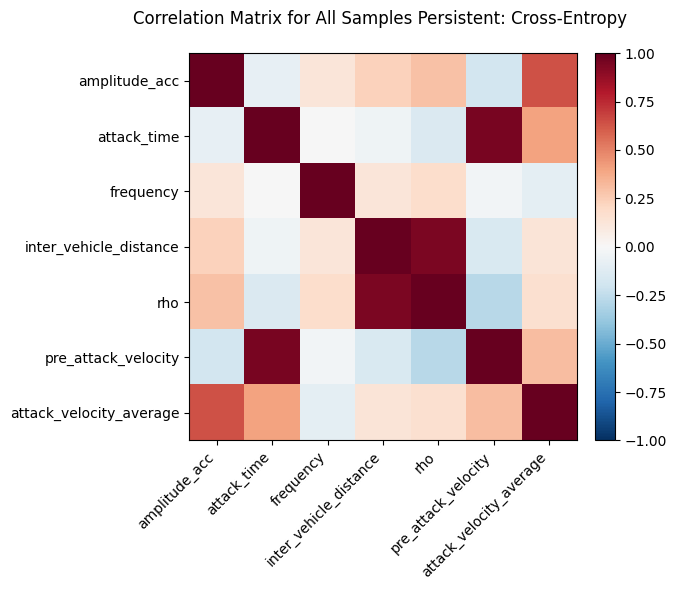

False ../outputs/persistent_mab


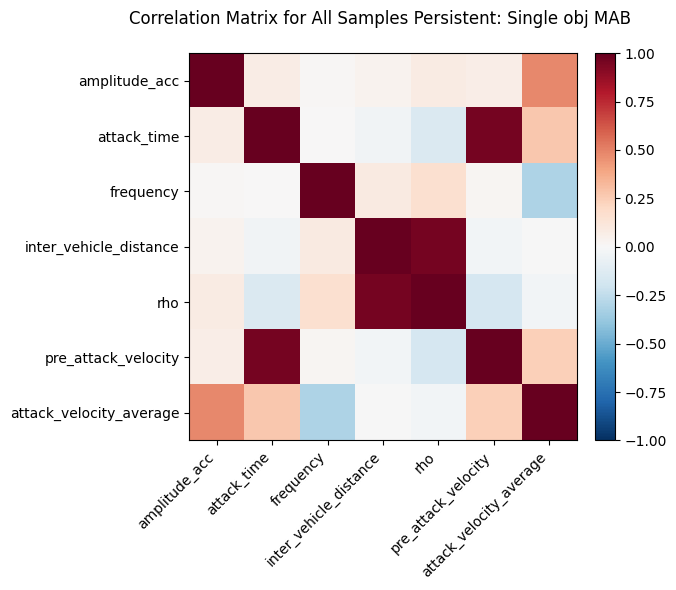

True ../outputs/persistent_mab_w_priority_equal


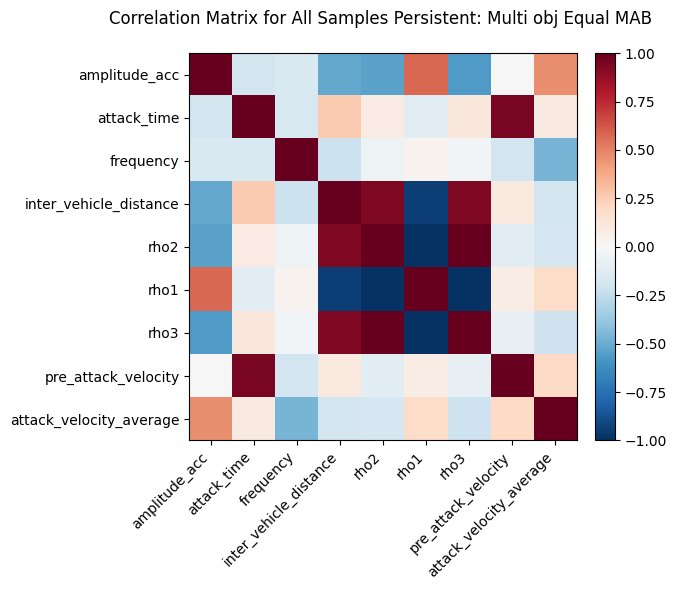

True ../outputs/persistent_mab_w_priority_1


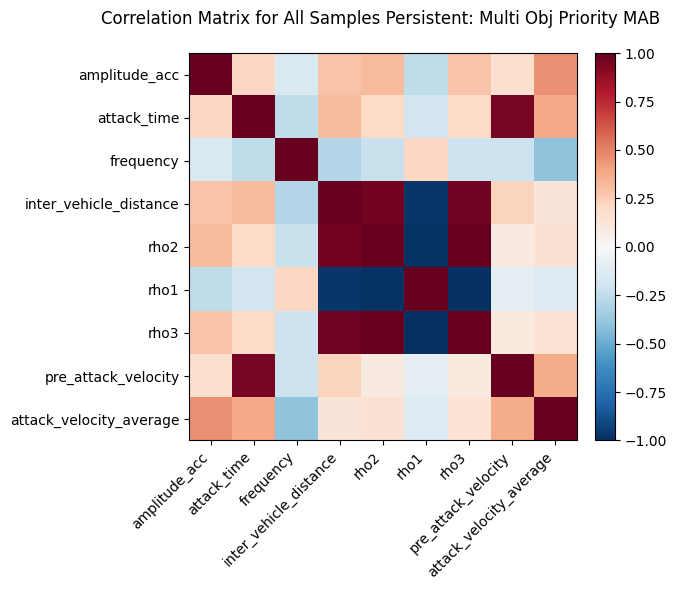

In [36]:
for i in per_paths:
    print(i[2], i[0])
    data = cofactor_preprocess(i[0],i[1],type="per",mult=i[2])
    cofactor_analysis_singular(data[3],data[2], "All Samples " + i[3])

False ../outputs/intermittent_ce


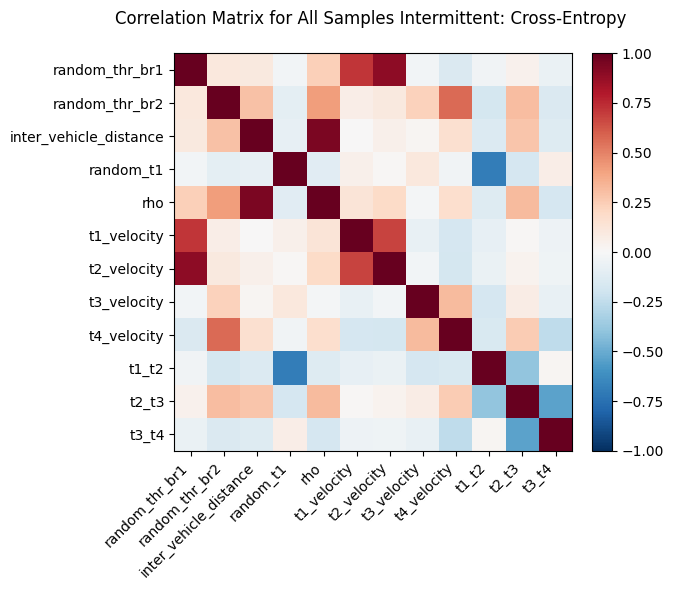

False ../outputs/intermittent_mab


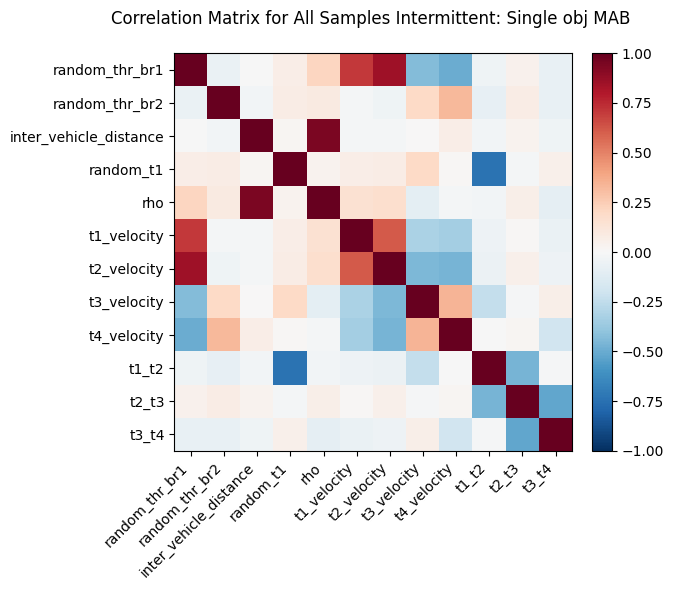

True ../outputs/intermittent_mab_w_priority_equal


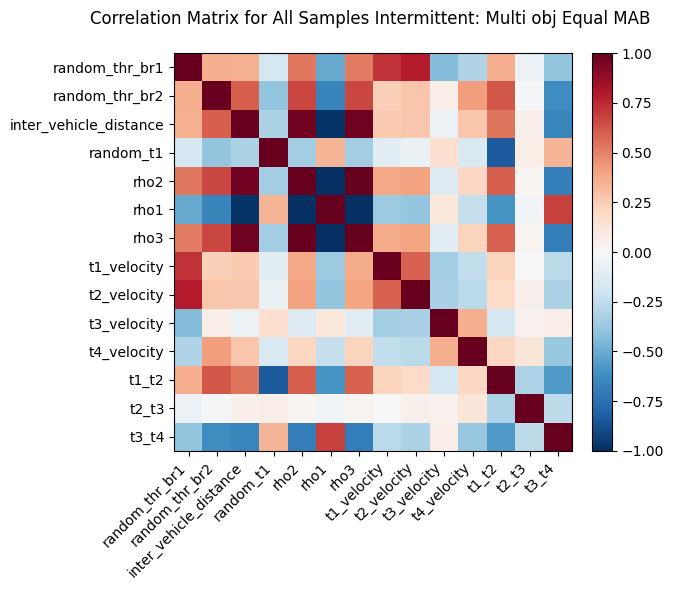

True ../outputs/intermittent_mab_w_priority_1


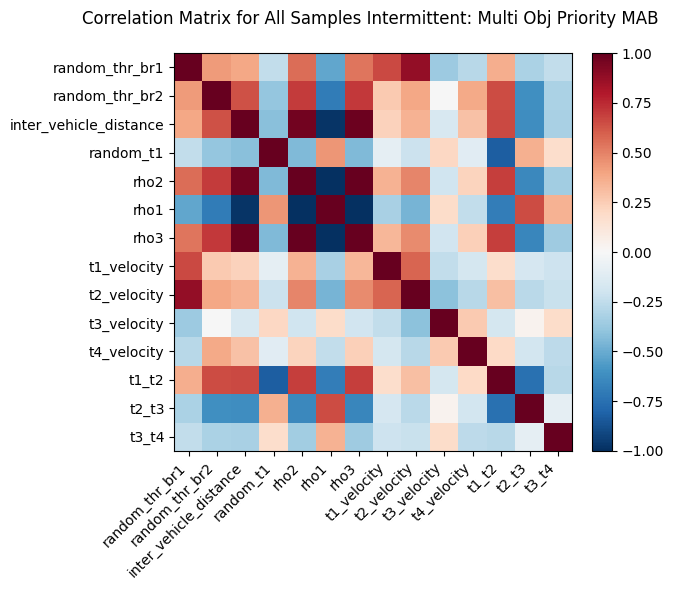

In [37]:
for i in int_paths:
    print(i[2], i[0])
    data = cofactor_preprocess(i[0],i[1],type="int",mult=i[2])
    cofactor_analysis_singular(data[3],data[2], "All Samples " + i[3])

In [ ]:
mab_int_data = cofactor_preprocess(int_mab_dir_path,int_mab_param_path, "int",mult=False)
ce_int_data= cofactor_preprocess(int_ce_dir_path,int_ce_param_path,"int",mult=False)

mab_per_data = cofactor_preprocess(per_mab_dir_path,per_mab_param_path, "per",mult=False)
ce_per_data= cofactor_preprocess(per_ce_dir_path,per_ce_param_path,"per",mult=False)

int_mab_equal_mult_data = cofactor_preprocess(int_mult_equal_dir_path, int_mult_equal_param_path, "int",mult=True)
int_mab_prio_mult_data = cofactor_preprocess(int_mult_prio_dir_path, int_mult_prio_param_path, "int",mult=True)

per_mab_equal_mult_data = cofactor_preprocess(per_mult_equal_dir_path, per_mult_equal_param_path, "per",mult=True)
per_mab_prio_mult_data = cofactor_preprocess(per_mult_prio_dir_path, per_mult_prio_param_path, "per",mult=True)

In [ ]:
#cofactor_analysis(int_mab_equal_mult_data[0],int_mab_equal_mult_data[1],int_mab_equal_mult_data[2], "Multi Objective MAB Equal")
#cofactor_analysis(int_mab_prio_mult_data[0],int_mab_prio_mult_data[1],int_mab_prio_mult_data[2], "Multi Objective MAB Priority")

In [ ]:
cofactor_comparison(per_mab_equal_mult_data[0],
                    per_mab_equal_mult_data[1],
                    per_mab_equal_mult_data[2], 
                    "Multi Objective MAB Equal: Persistent",
                    per_mab_prio_mult_data[0],
                    per_mab_prio_mult_data[1],
                    per_mab_prio_mult_data[2], 
                    "Multi Arm Bandit Priority: Persistent", 
                    )
cofactor_comparison(mab_per_data[0],mab_per_data[1],mab_per_data[2], "Single Obj Mab: Persistent",ce_per_data[0],ce_per_data[1],ce_per_data[2], "Cross Entropy: Persistent")

In [ ]:
cofactor_comparison(int_mab_equal_mult_data[0],
                    int_mab_equal_mult_data[1],
                    int_mab_equal_mult_data[2], 
                    "Muli Objective MAB",
                    mab_int_data[0],
                    mab_int_data[1],
                    mab_int_data[2], 
                    "Multi Arm Bandit Single", 
                    )

cofactor_analysis_singular(int_mab_equal_mult_data[3],int_mab_equal_mult_data[2], "All Samples Equal MAB")

# PCA Analysis

In [40]:
def pca_preprocess(dir_path,file_path,type,mult):
    data, count = read_folder(dir_path,file_path,type,mult_obj=mult)
    if mult == True:
        data =data.drop(columns=["rho1","rho2","rho3","idx"])
    else:
        data = data.drop(columns=["idx", "rho"])
    if type=="int":
        data = data.drop(columns=["random_t2", "random_t3", "random_t4"])

    cols = data.columns
    data, _,_ = distinguish_events(data,count) #  isolate counter examples
    data = StandardScaler().fit_transform(data)

    pca= PCA()
    pca.fit(data)

    return (pca,cols)

In [41]:
def graph_pca_comparison(pca1, pca2, title1, title2, original_features):
    # Generate feature_df for each PCA from their components
    feature_df1 = pd.DataFrame(pca1.components_, columns=original_features)
    feature_df2 = pd.DataFrame(pca2.components_, columns=original_features)

    # Plot 1: Explained Variance Ratio
    fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    # Plot PCA1 explained variance ratio
    ax1.plot(range(1, len(pca1.explained_variance_ratio_) + 1), pca1.explained_variance_ratio_, marker='o')
    ax1.set_xlabel('Principal Components')
    ax1.set_ylabel('Explained Variance Ratio')
    ax1.set_title(f'Explained Variance: {title1}')
    ax1.grid(True)

    # Plot PCA2 explained variance ratio
    ax2.plot(range(1, len(pca2.explained_variance_ratio_) + 1), pca2.explained_variance_ratio_, marker='o')
    ax2.set_xlabel('Principal Components')
    ax2.set_ylabel('Explained Variance Ratio')
    ax2.set_title(f'Explained Variance: {title2}')
    ax2.grid(True)

    # Adjust layout and show
    plt.tight_layout()
    plt.show()

    # Plot 2: Cumulative Explained Variance Ratio
    fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    # Plot PCA1 cumulative explained variance
    cumulative_variance1 = np.cumsum(pca1.explained_variance_ratio_)
    ax1.plot(range(1, len(cumulative_variance1) + 1), cumulative_variance1, marker='o', color='orange')
    ax1.set_xlabel('Principal Components')
    ax1.set_ylabel('Cumulative Explained Variance Ratio')
    ax1.set_title(f'Cumulative Explained Variance: {title1}')
    ax1.grid(True)

    # Plot PCA2 cumulative explained variance
    cumulative_variance2 = np.cumsum(pca2.explained_variance_ratio_)
    ax2.plot(range(1, len(cumulative_variance2) + 1), cumulative_variance2, marker='o', color='orange')
    ax2.set_xlabel('Principal Components')
    ax2.set_ylabel('Cumulative Explained Variance Ratio')
    ax2.set_title(f'Cumulative Explained Variance: {title2}')
    ax2.grid(True)

    # Adjust layout and show
    plt.tight_layout()
    plt.show()

    # Plot 3: Heatmap of PCA component loadings
    fig3, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    # Plot PCA1 component loadings heatmap
    sns.heatmap(feature_df1.T, cmap='coolwarm', annot=True, fmt='.2f', ax=ax1)
    ax1.set_title(f'PCA Component Loadings: {title1}')
    ax1.set_xlabel('Principal Component')
    ax1.set_ylabel('Original Features')
    ax1.set_xticks(range(feature_df1.shape[0]))
    ax1.set_xticklabels([f'{i}' for i in range(feature_df1.shape[0])])

    # Plot PCA2 component loadings heatmap
    sns.heatmap(feature_df2.T, cmap='coolwarm', annot=True, fmt='.2f', ax=ax2)
    ax2.set_title(f'PCA Component Loadings: {title2}')
    ax2.set_xlabel('Principal Component')
    ax2.set_ylabel('Original Features')
    ax2.set_xticks(range(feature_df2.shape[0]))
    ax2.set_xticklabels([f'{i}' for i in range(feature_df2.shape[0])])

    # Adjust layout and show
    plt.tight_layout()
    plt.show()

In [43]:

def graph_pca_variance(pca, title, original_features):
    # Generate the feature_df from PCA components
    feature_vals = pca.components_
    feature_df = pd.DataFrame(feature_vals, columns=original_features)

    # Create a figure with 3 subplots (1 row, 3 columns)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

    # Plot 1: Explained Variance Ratio
    ax1.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o')
    ax1.set_xlabel('Principal Components')
    ax1.set_ylabel('Explained Variance Ratio')
    ax1.set_title(f'Explained Variance by Principal Components: {title}')
    ax1.grid(True)

    # Plot 2: Cumulative Explained Variance Ratio
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    ax2.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', color='orange')
    ax2.set_xlabel('Principal Components')
    ax2.set_ylabel('Cumulative Explained Variance Ratio')
    ax2.set_title(f'Cumulative Explained Variance by Principal Components: {title}')
    ax2.grid(True)

    # Plot 3: Heatmap of the PCA component loadings
    ax3 = plt.subplot(1, 3, 3)
    sns.heatmap(feature_df.T, cmap='coolwarm', annot=True, fmt='.2f', ax=ax3)
    ax3.set_title(f'PCA Component Loadings: {title}')
    ax3.set_xlabel('Principal Component')
    ax3.set_ylabel('Original Features')
    components = feature_df.shape[0]
    ax3.set_xticks(range(components))
    ax3.set_xticklabels([str(i) for i in range(components)])

    # Adjust the layout to avoid overlap
    plt.tight_layout()

    # Show all plots
    plt.show()



In [ ]:
def graph_pca_heatmap(pca, title, original_features):
    num_components = 4
    feature_df = pd.DataFrame(pca.components_[:num_components], columns=original_features)
    explained_variance = pca.explained_variance_ratio_[:num_components]

    plt.figure(figsize=(10, 6))
    sns.heatmap(feature_df.T, cmap='coolwarm', annot=True, fmt='.2f', cbar_kws={'label': 'Component Loadings'})
    plt.title(f'PCA Component Loadings: {title}')
    plt.xlabel('Principal Component')
    plt.ylabel('Original Features')

    explained_variance_labels = [f'PC{i+1}\n({variance:.2f}%)' for i, variance in enumerate(explained_variance)]
    plt.xticks(ticks=np.arange(len(explained_variance)), labels=explained_variance_labels, rotation=45)
    plt.tight_layout()
    #path = f"../visuals/pca/{title}" + ".png"
    #plt.savefig(path.replace(" ", "").replace(":","_"))
    plt.show()


# PCA Comparisions

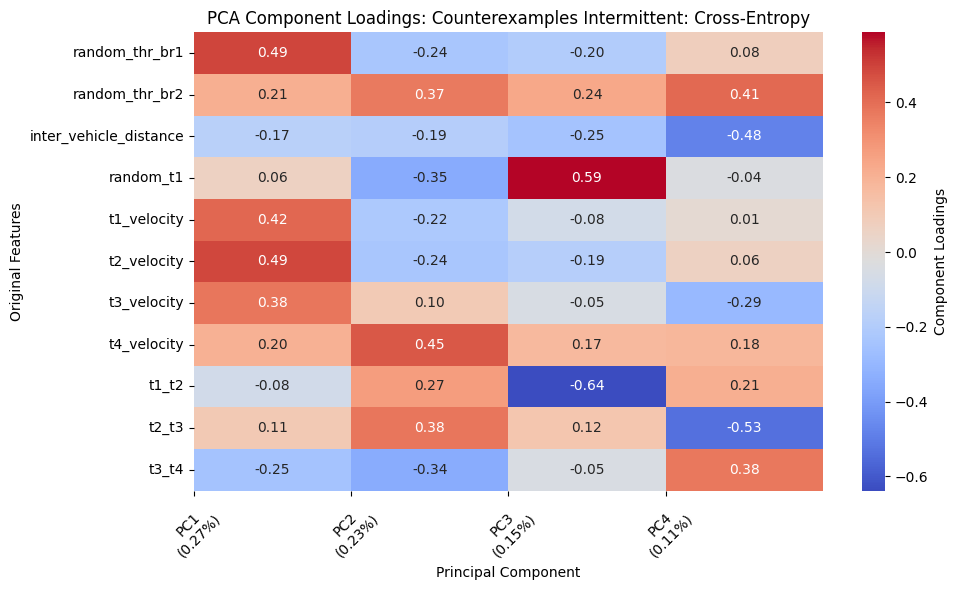

In [ ]:
for i in int_paths:
    data,cols = pca_preprocess(i[0],i[1],type="int",mult=i[2])
    graph_pca_heatmap(data, "Counterexamples " + i[3],cols)

for i in per_paths:
    data,cols = pca_preprocess(i[0],i[1],type="per",mult=i[2])
    graph_pca_heatmap(data, "Counterexamples " + i[3],cols)


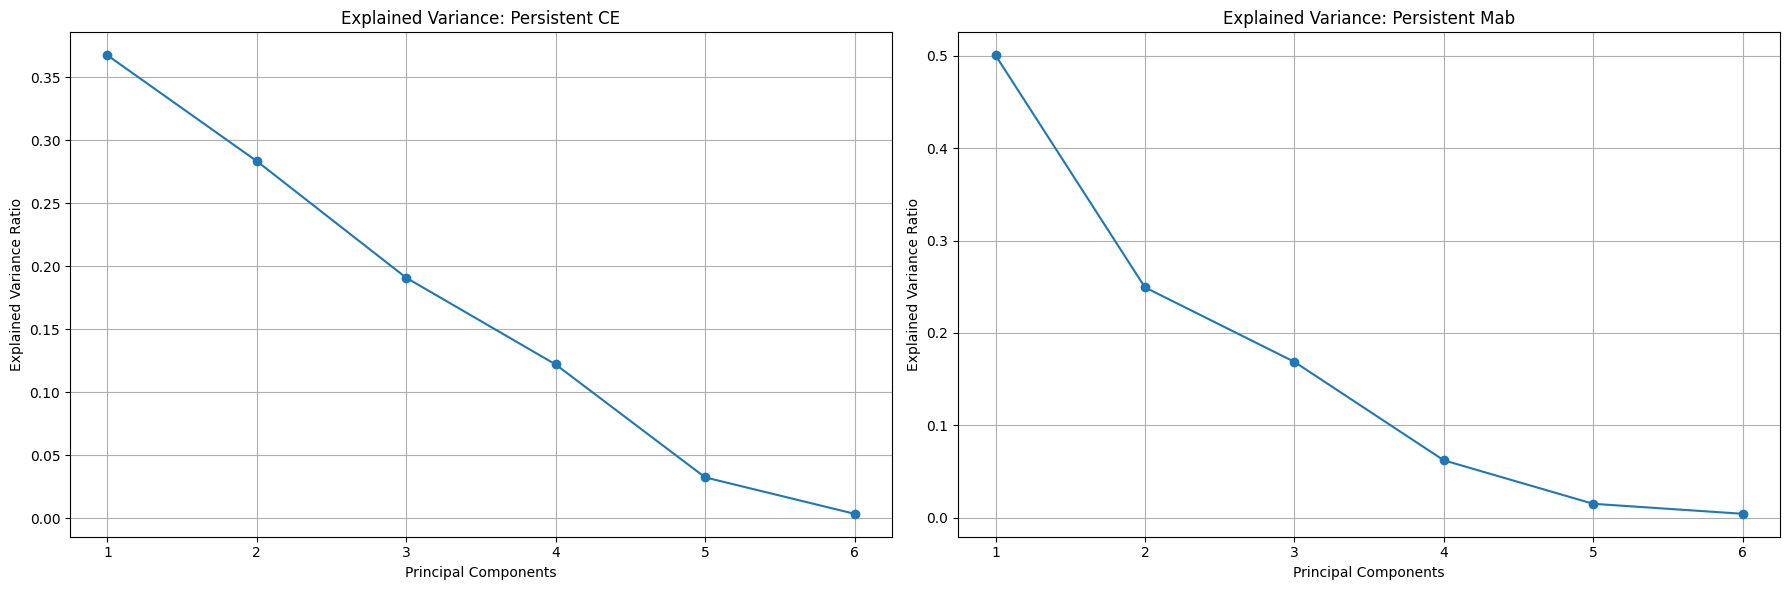

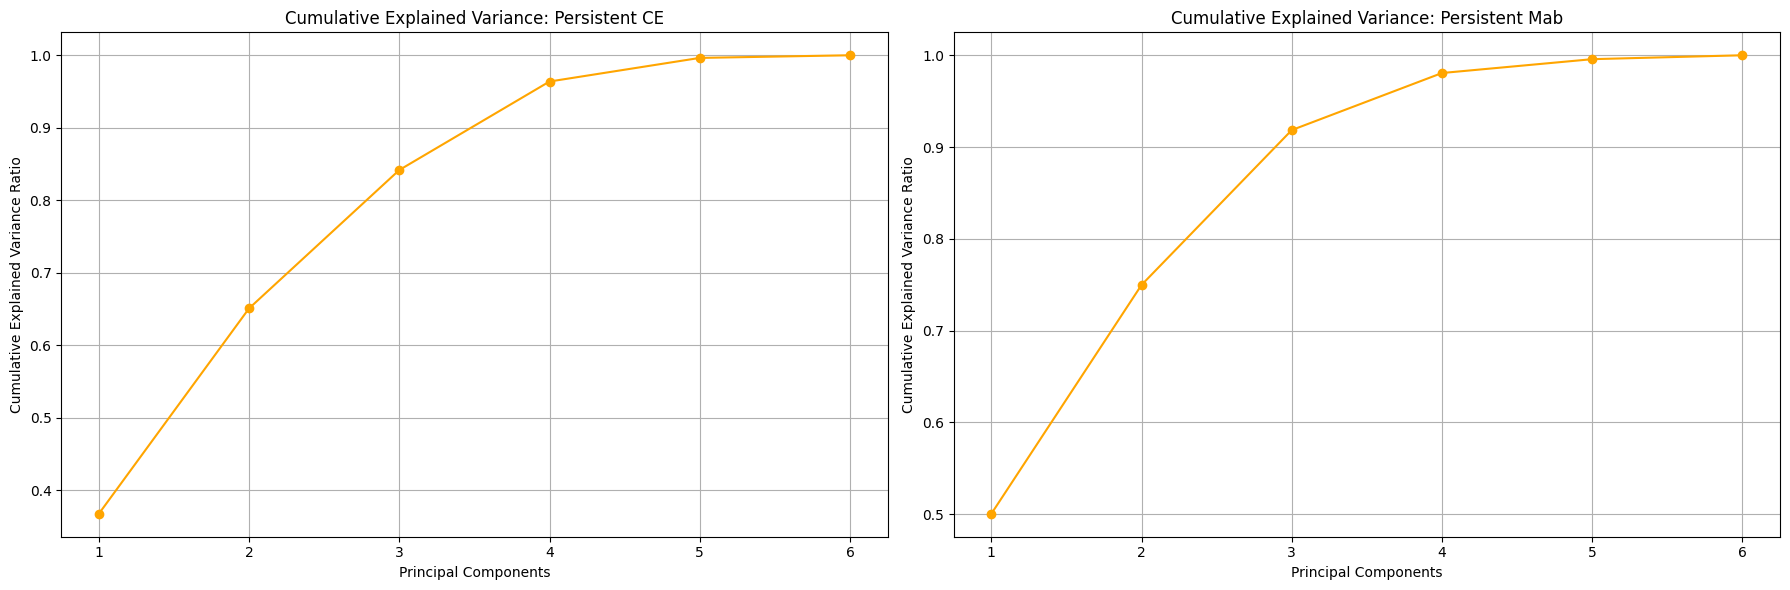

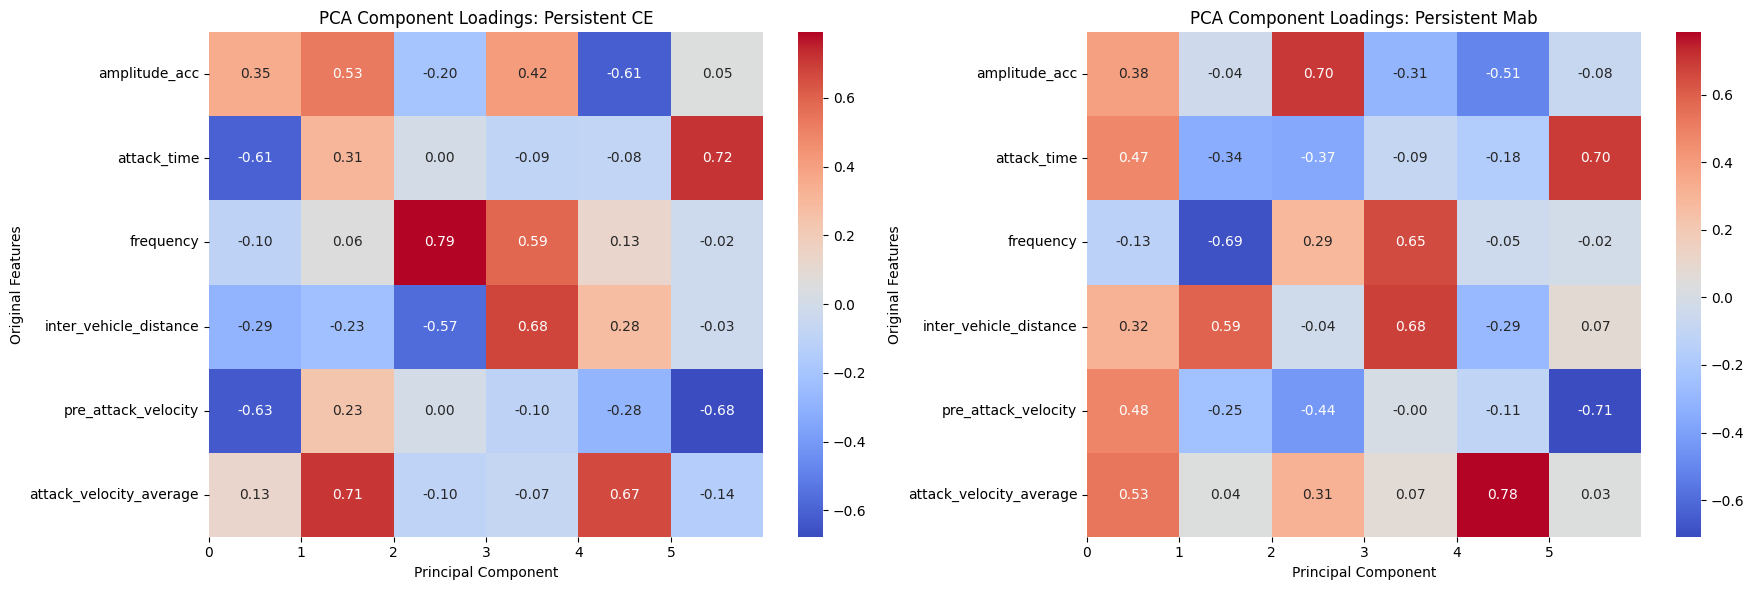

In [ ]:
per_ce_pca,cols = pca_preprocess(per_ce_dir_path,per_ce_param_path,"per",mult=False)
per_mab_pca,cols = pca_preprocess(per_mab_dir_path,per_mab_param_path,"per",mult=False)

graph_pca_comparison(per_ce_pca, per_mab_pca,"Persistent CE","Persistent Mab",cols)

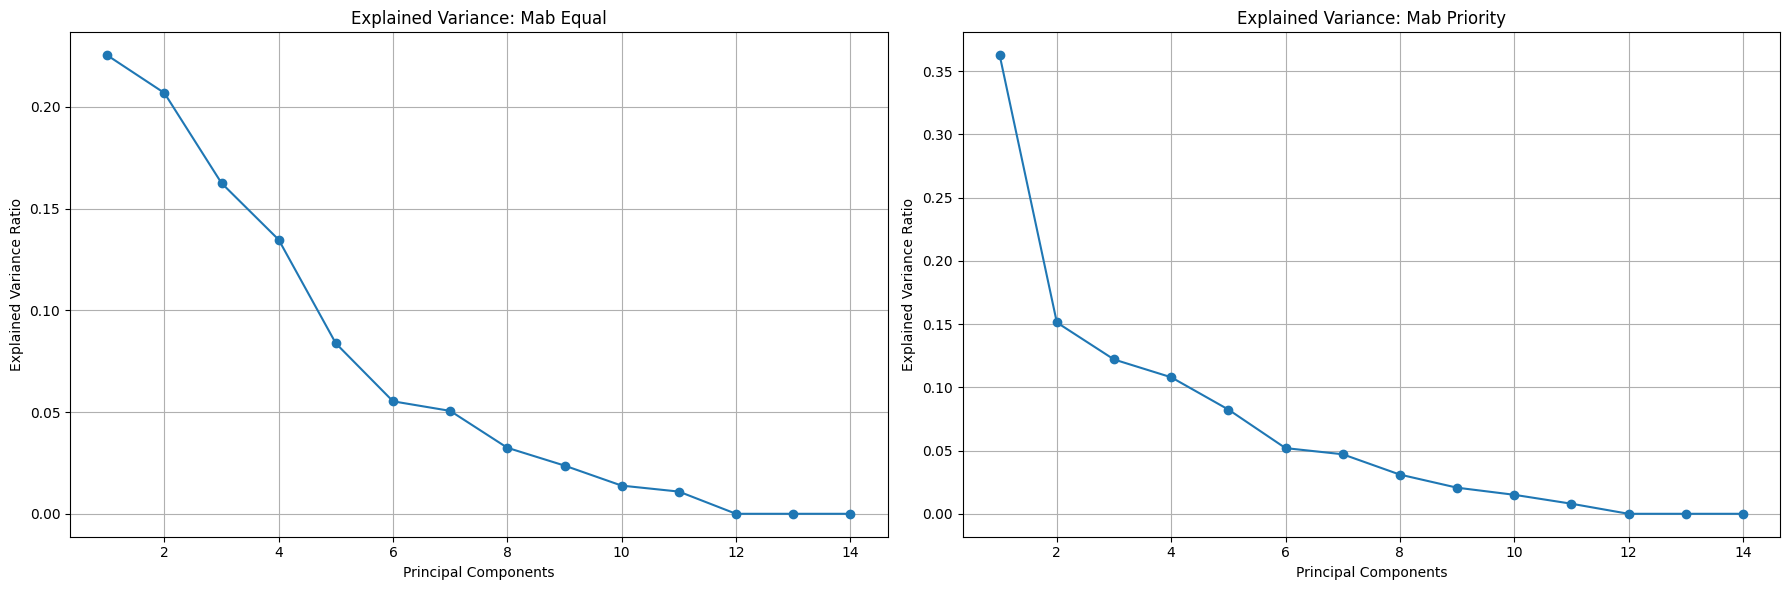

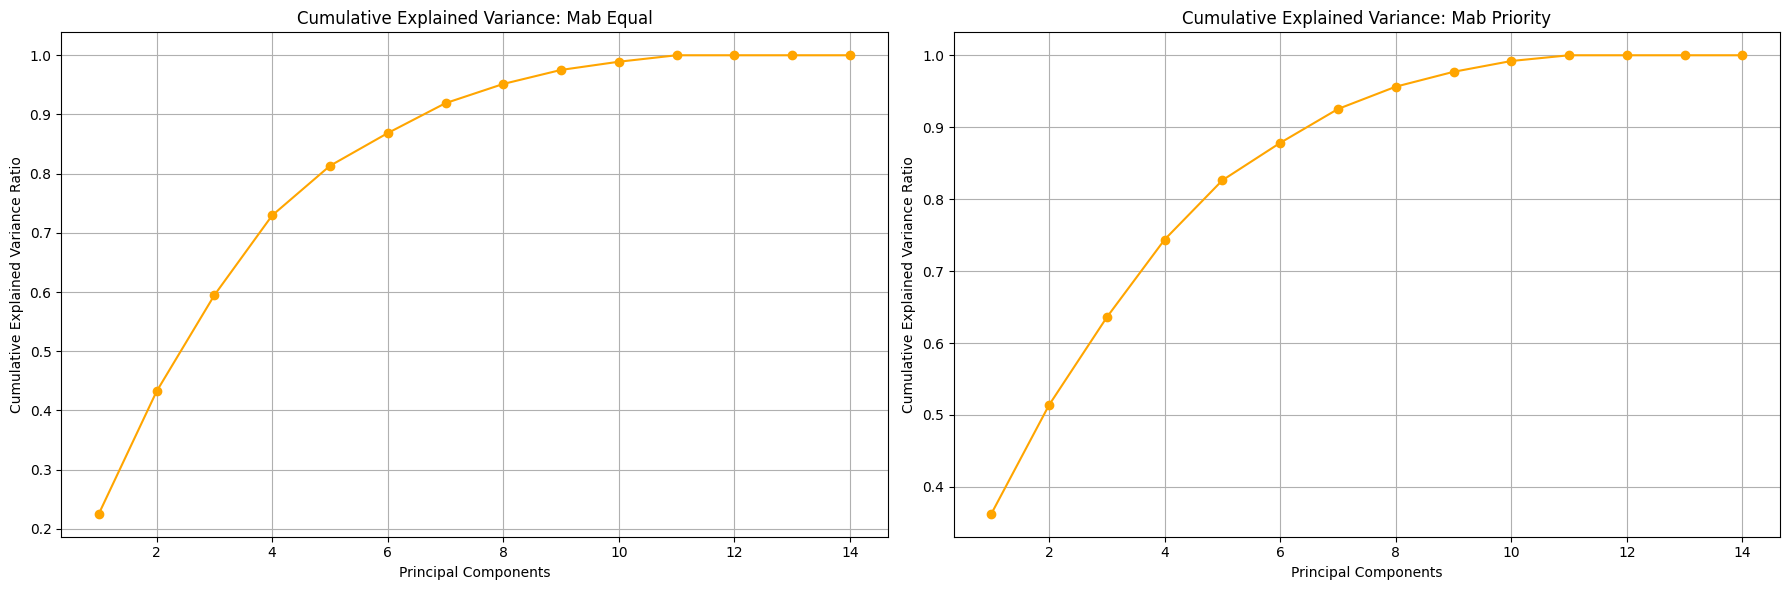

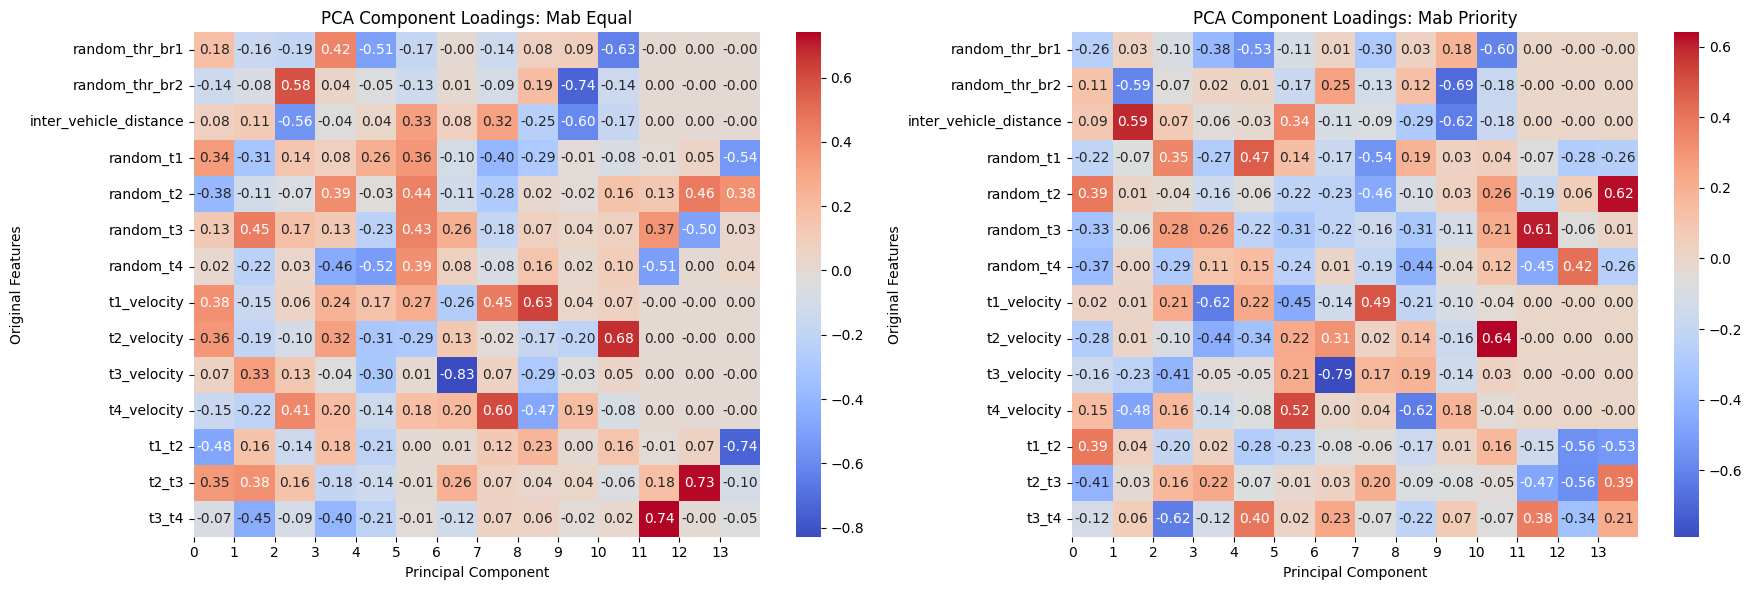

In [ ]:
int_mab_equal_mult_pca,cols1 = pca_preprocess(int_mult_equal_dir_path, int_mult_equal_param_path,"int",True)
int_mab_prio_mult_pca,cols2 = pca_preprocess(int_mult_prio_dir_path, int_mult_prio_param_path, "int", True)

graph_pca_comparison(int_mab_equal_mult_pca,int_mab_prio_mult_pca,"Mab Equal","Mab Priority",cols1)


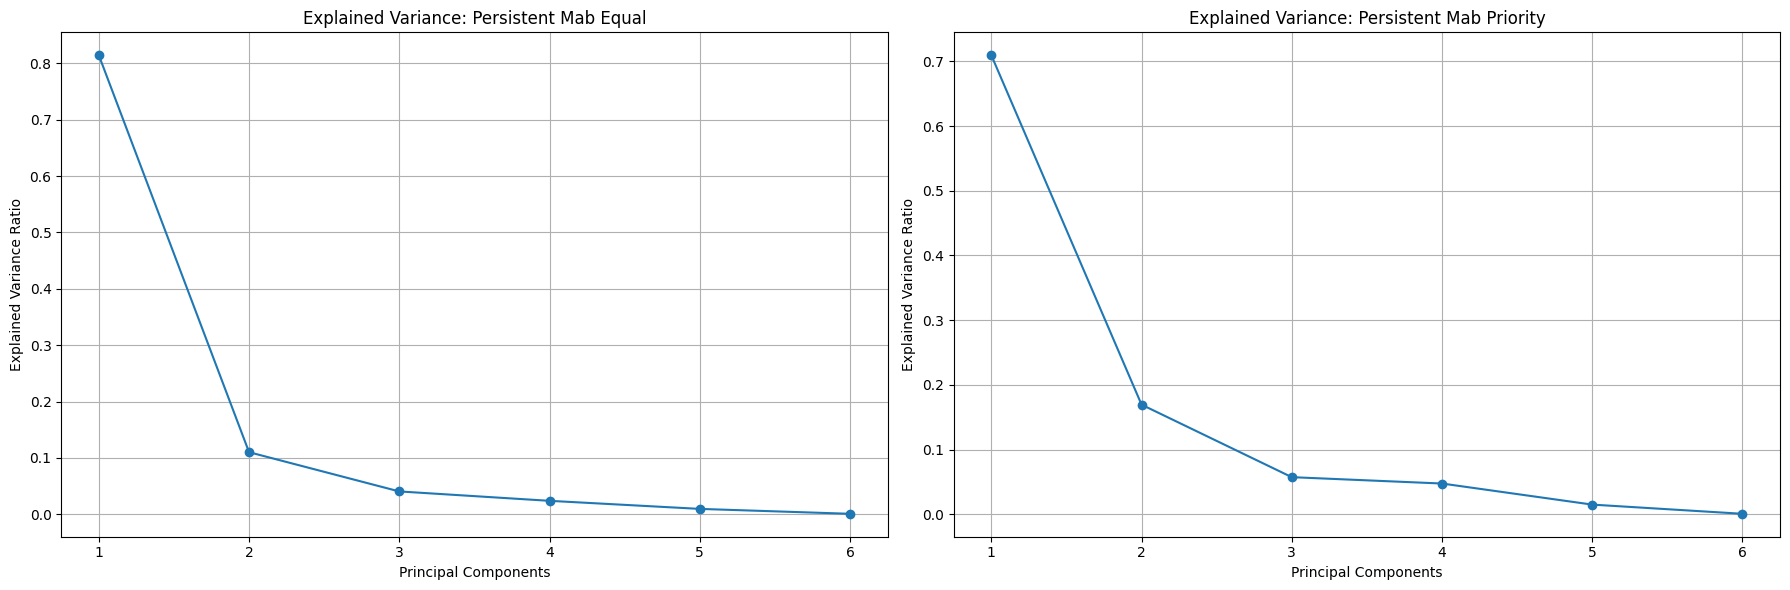

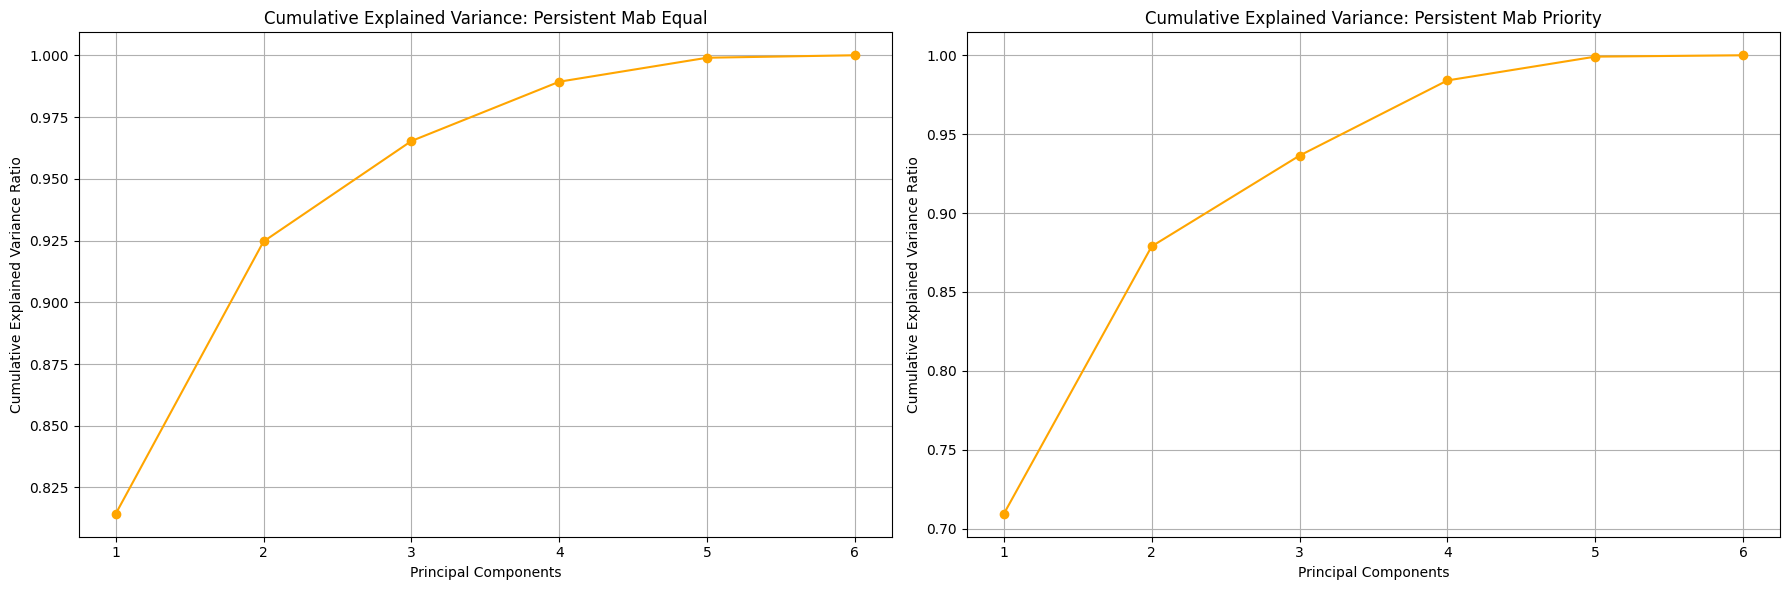

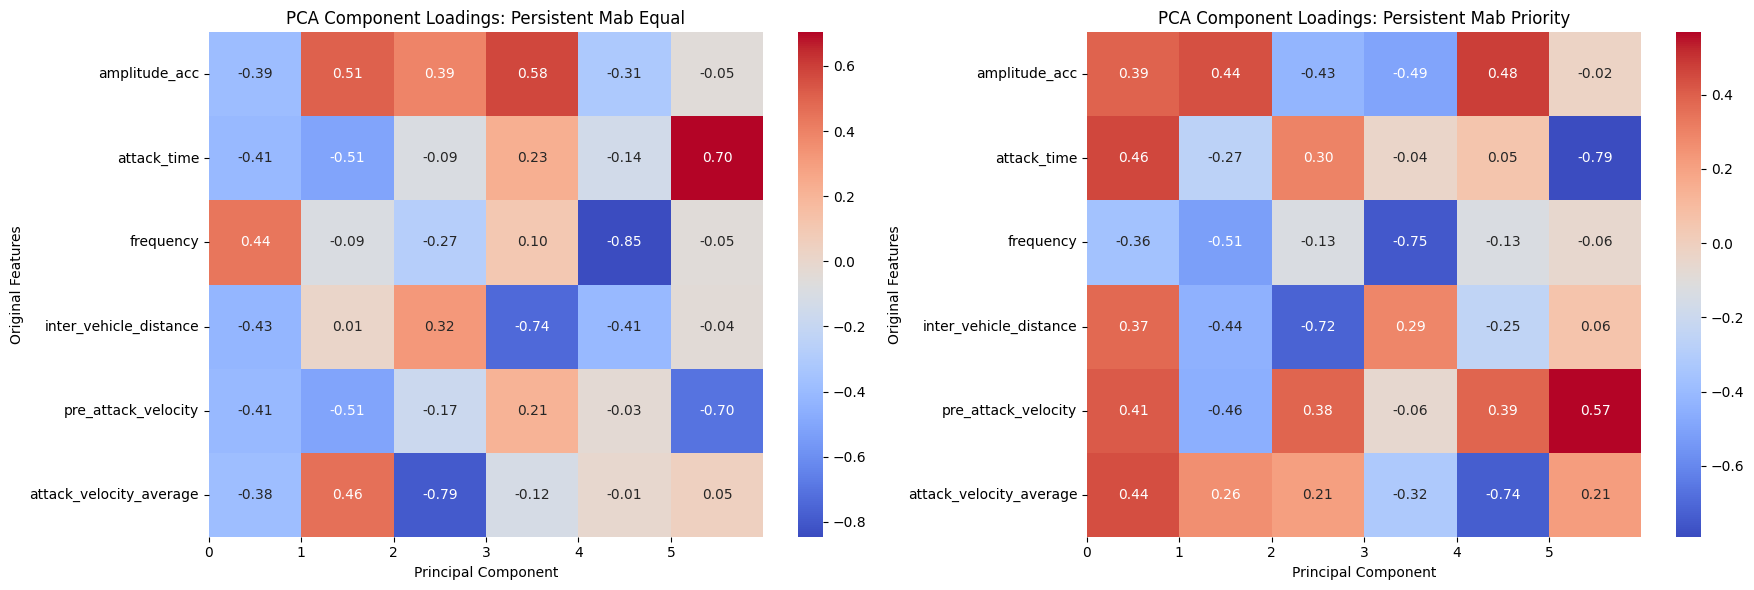

In [ ]:
per_mab_equal_mult_pca,cols1 = pca_preprocess(per_mult_equal_dir_path, per_mult_equal_param_path,"per",True)
per_mab_prio_mult_pca,cols2 = pca_preprocess(per_mult_prio_dir_path, per_mult_prio_param_path, "per", True)

graph_pca_comparison(per_mab_equal_mult_pca,per_mab_prio_mult_pca,"Persistent Mab Equal","Persistent Mab Priority",cols1)


# Clustering

In [ ]:
def cluster_preprocess(dir_path,file_path,type):
    data, count = read_folder(dir_path,file_path,type)
    data = data.drop(columns=["idx", "rho"])
    cols = data.columns
    data, _,_ = distinguish_events(data,count) #  isolate counter examples
    data = StandardScaler().fit_transform(data)

    return (data,cols)

In [ ]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

range_n_clusters = range(2,8)

X, _ = cluster_preprocess(int_mab_dir_path, int_mab_param_path, "int")
print(len(X))

cluster = AffinityPropagation(random_state=3).fit(X)

cluster_centers_indices = cluster.cluster_centers_indices_
labels = cluster.labels_
n_clusters_ = len(cluster_centers_indices)

NameError: name 'int_mab_dir_path' is not defined

In [ ]:
# Assuming `n_clusters_`, `labels`, `X`, and `cluster_centers_indices` are already defined

plt.close("all")
plt.figure(1)
plt.clf()

# Use linspace to create a color cycle based on the number of unique clusters
colors = plt.cycler("color", plt.cm.viridis(np.linspace(0, 1, n_clusters_)))

for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.scatter(
        X[class_members, 0], X[class_members, 1], color=col["color"], marker="."
    )
    plt.scatter(
        cluster_center[0], cluster_center[1], s=14, color=col["color"], marker="o"
    )
    for x in X[class_members]:
        plt.plot(
            [cluster_center[0], x[0]], [cluster_center[1], x[1]], color=col["color"]
        )

plt.title(f"Estimated number of clusters: {n_clusters_}")
plt.show()


NameError: name 'n_clusters_' is not defined

<Figure size 640x480 with 0 Axes>